We currently have a model that can deal with one character of previous context. But the precition was not good enough.

* More context? way too many rows => expensive to calculate
* MLP

In [1]:
import torch
import torch.nn.functional as F

# Data

In [2]:
names = open("names.txt").read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
vocab = sorted(set(''.join(names)))
vocab = ["."] + vocab
len(vocab)

27

In [4]:
stoi = {s:i for i, s in enumerate(vocab)}
itos = {i:s for s, i in stoi.items()}

In [5]:
block_size = 5 # context length
xs, ys = [], []

for name in names[:5]:
    context = [0] * block_size
    print(name)
    for ch in name+".":
        idx = stoi[ch]
        xs.append(context)
        ys.append(idx)
        print(f"{''.join([itos[i] for i in context])} -------> {itos[idx]}")
        context = context[1:] + [idx]
xs, ys = torch.tensor(xs), torch.tensor(ys)

emma
..... -------> e
....e -------> m
...em -------> m
..emm -------> a
.emma -------> .
olivia
..... -------> o
....o -------> l
...ol -------> i
..oli -------> v
.oliv -------> i
olivi -------> a
livia -------> .
ava
..... -------> a
....a -------> v
...av -------> a
..ava -------> .
isabella
..... -------> i
....i -------> s
...is -------> a
..isa -------> b
.isab -------> e
isabe -------> l
sabel -------> l
abell -------> a
bella -------> .
sophia
..... -------> s
....s -------> o
...so -------> p
..sop -------> h
.soph -------> i
sophi -------> a
ophia -------> .


In [6]:
xs.shape, xs.dtype, ys.shape, ys.dtype

(torch.Size([32, 5]), torch.int64, torch.Size([32]), torch.int64)

# Embedding

Our vocab size is 27 and we want to map them into 2-D space. In original paper from Bengio, they have 17,000 words and then map them into 30-D space.

In [7]:
C = torch.randn([27, 2])
C

tensor([[-0.5775,  1.3584],
        [-0.0939, -1.1264],
        [-0.3293, -1.3526],
        [-0.8306,  1.2893],
        [-1.2242,  0.9398],
        [-0.1786, -0.3359],
        [-0.0107, -0.2524],
        [-0.0263,  1.4135],
        [-0.5557,  1.6482],
        [ 0.4458,  0.7976],
        [-0.7156,  0.7521],
        [-1.5763, -0.7619],
        [ 0.6223, -1.9367],
        [-0.8888,  0.9732],
        [ 0.4173,  0.1467],
        [ 0.0685,  0.1718],
        [-0.0896,  2.4715],
        [-0.0955,  1.0305],
        [ 0.3147, -0.5706],
        [ 1.1972, -1.7703],
        [-1.0517,  1.5044],
        [-0.2780,  0.2157],
        [ 0.6396,  0.5474],
        [ 1.2991, -0.0221],
        [-0.0562, -0.1321],
        [-0.5769,  1.8124],
        [-1.0323, -0.8040]])

In [8]:
xenc = F.one_hot(torch.tensor(5), num_classes=27).float()
# which is equal to C[5]
# 5 th row will be plucked out.
C[5], C[5] == xenc @ C

(tensor([-0.1786, -0.3359]), tensor([True, True]))

In [9]:
xs

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  5],
        [ 0,  0,  0,  5, 13],
        [ 0,  0,  5, 13, 13],
        [ 0,  5, 13, 13,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 15],
        [ 0,  0,  0, 15, 12],
        [ 0,  0, 15, 12,  9],
        [ 0, 15, 12,  9, 22],
        [15, 12,  9, 22,  9],
        [12,  9, 22,  9,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1],
        [ 0,  0,  0,  1, 22],
        [ 0,  0,  1, 22,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  9],
        [ 0,  0,  0,  9, 19],
        [ 0,  0,  9, 19,  1],
        [ 0,  9, 19,  1,  2],
        [ 9, 19,  1,  2,  5],
        [19,  1,  2,  5, 12],
        [ 1,  2,  5, 12, 12],
        [ 2,  5, 12, 12,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 19],
        [ 0,  0,  0, 19, 15],
        [ 0,  0, 19, 15, 16],
        [ 0, 19, 15, 16,  8],
        [19, 15, 16,  8,  9],
        [15, 16,  8,  9,  1]])

In [10]:
C[xs].shape, C[xs][1, 4], C[xs][1, 4] == C[5] 

(torch.Size([32, 5, 2]), tensor([-0.1786, -0.3359]), tensor([True, True]))

In [11]:
emb = C[xs]
emb.shape

torch.Size([32, 5, 2])

# Hidden Layer

In [12]:
W = torch.randn([10, 100])
emb @ W

RuntimeError: mat1 and mat2 shapes cannot be multiplied (160x2 and 10x100)

In [13]:
# Method 1: Extract and concat
concated_1 = torch.concat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :], emb[:, 3, :], emb[:, 4, :]), dim=1)
(concated_1 @ W).shape

torch.Size([32, 100])

In [14]:
# Method 2: Unbind
unbind_emb = torch.unbind(emb, dim=1)
concated_2 = torch.concat(unbind_emb, dim=1)
(concated_2 @ W).shape

torch.Size([32, 100])

In [15]:
# Method 3: View
viewed_emb = emb.view(32, -1)
concated_1 == concated_2, concated_1 == viewed_emb

(tensor([[True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
      

In [16]:
b = torch.rand(100)
hidden = emb.view(32, -1) @ W + b # b is broadcasted. emb: [32, 100] b: [1, 100] -> [32, 100]
hiddden_out = torch.tanh(hidden)
hiddden_out.shape

torch.Size([32, 100])

# Output Layer

In [17]:
W2 = torch.randn([100, 27])
b2 = torch.randn(27)
logits = hiddden_out @ W2 + b2

Previously how we did

In [18]:
logits = hiddden_out @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape, probs[0].sum()

(torch.Size([32, 27]), tensor(1.))

In [19]:
output = probs[torch.arange(32), ys] # Output prob at correct position, ideally all of them should be 1
output.shape, output

(torch.Size([32]),
 tensor([8.5547e-05, 7.8384e-10, 3.8342e-11, 1.7917e-05, 4.5546e-02, 1.3712e-05,
         1.9712e-05, 4.2102e-09, 5.6138e-08, 1.3280e-04, 7.3245e-11, 1.1327e-07,
         5.8820e-06, 7.9173e-10, 4.0476e-06, 2.6937e-06, 4.9228e-09, 2.1195e-13,
         1.6063e-06, 1.7111e-05, 1.6646e-13, 2.2981e-10, 5.1877e-11, 2.0077e-12,
         2.4298e-17, 2.2391e-13, 1.7643e-07, 1.3428e-07, 1.1967e-05, 5.5457e-08,
         2.1472e-06, 3.4515e-07]))

In [20]:
loss = -output.log().mean()
loss

tensor(17.5763)

More efficient in torch

In [21]:
test_x = torch.tensor([-5, 5, 100])
how_torch_did_test_x = test_x - 100
test_x.exp(), how_torch_did_test_x.exp()

(tensor([6.7379e-03, 1.4841e+02,        inf]),
 tensor([0.0000e+00, 5.5211e-42, 1.0000e+00]))

In [22]:
loss_torch = F.cross_entropy(logits, ys)
loss_torch

tensor(17.5763)

# Put above together

In [150]:
block_size = 5 # context length
xs, ys = [], []

for name in names:
    context = [0] * block_size
#     print(name)
    for ch in name+".":
        idx = stoi[ch]
        xs.append(context)
        ys.append(idx)
#         print(f"{''.join([itos[i] for i in context])} -------> {itos[idx]}")
        context = context[1:] + [idx]
xs, ys = torch.tensor(xs), torch.tensor(ys)

In [151]:
xs.shape, ys.shape

(torch.Size([228146, 5]), torch.Size([228146]))

In [152]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([27, 2], generator=g) # 32x5x27 * 27* 2 => 32x5x2
W1 = torch.randn([10, 100], generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn([100, 27], generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [153]:
sum(p.nelement() for p in parameters)

3881

## Too slow for training entire dataset one time
Minibatch would be helpful

In [112]:
steps = 1000
for step in range(steps):
    # Minibatch construct
    # Randomly sample from xs
    # Sample 32 samples from all xs indices
    idx = torch.randint(0, xs.shape[0], (32,))
    
    # Fordward Pass
    emb = C[xs[idx]]
    h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[idx])
    if step % 100 == 0:
        print(f"Step: {step}/{steps}, loss: {loss.item()}")

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    with torch.no_grad():
        for p in parameters:
            p += -0.1 * p.grad

Step: 0/1000, loss: 2.3309836387634277
Step: 100/1000, loss: 2.6962544918060303
Step: 200/1000, loss: 2.463359832763672
Step: 300/1000, loss: 2.456885814666748
Step: 400/1000, loss: 2.4584414958953857
Step: 500/1000, loss: 2.69327712059021
Step: 600/1000, loss: 2.0184473991394043
Step: 700/1000, loss: 2.32228684425354
Step: 800/1000, loss: 2.721691131591797
Step: 900/1000, loss: 2.231600761413574


In [99]:
# Prediction
logits.max(dim=1)

torch.return_types.max(
values=tensor([5.1057, 3.8263, 5.0219, 2.6338, 2.4133, 4.1865, 4.4060, 4.5111, 4.4304,
        3.6644, 3.9474, 0.8741, 3.5139, 1.7586, 5.8144, 2.3894, 4.2333, 1.6403,
        5.8088, 2.6058, 2.9838, 2.3170, 2.8101, 5.1666, 1.6403, 2.1431, 3.5724,
        0.6373, 3.2650, 5.0537, 3.8294, 1.6403], grad_fn=<MaxBackward0>),
indices=tensor([ 0,  0,  0, 12,  1,  0,  0,  0,  9,  1,  1, 12,  0, 14,  0,  0,  0,  1,
         0, 14,  0,  1,  0,  0,  1,  1,  0, 14, 14,  0,  0,  1]))

In [101]:
# Label
ys[idx]

tensor([ 0,  0,  0,  7,  1, 12, 15,  0,  5,  9,  1, 25, 22, 14,  0,  0,  5, 12,
         0, 14, 12,  5,  5,  0,  9,  1,  0,  9, 14,  0,  0,  1])

In [113]:
# Loss over all samples
emb = C[xs]
h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ys)
loss

tensor(2.4054, grad_fn=<NllLossBackward0>)

## Loss decrease slow
Find a better learning rate

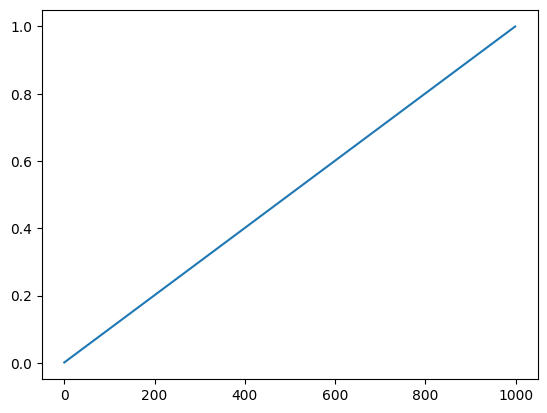

In [120]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(1000), torch.linspace(0.001, 1, 1000))

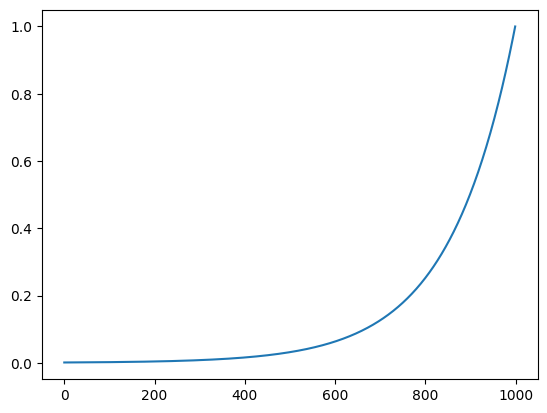

In [118]:
plt.plot(torch.arange(1000), 10 ** torch.linspace(-3, 0, 1000))

In [162]:
import math
steps = 10000
lre = torch.linspace(-3, 0, 1000)
lrs = 10 **lre
lri = []
lossi = []

for step in range(steps):
    # Minibatch construct
    # Randomly sample from xs
    # Sample 32 samples from all xs indices
    idx = torch.randint(0, xs.shape[0], (32,))
    
    # Fordward Pass
    emb = C[xs[idx]]
    h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[idx])
#     if step % 100 == 0:
#         print(f"Step: {step}/{steps}, loss: {loss.item()}")
    
#     lr = lrs[step]
#     lri.append(math.log(lr,10))
#     lossi.append(loss.item())
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    with torch.no_grad():
        for p in parameters:
            p += -0.01 * p.grad

In [163]:
# Loss over all samples
emb = C[xs]
h = torch.tanh(emb.view(-1, 10) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ys)
loss

tensor(2.3335, grad_fn=<NllLossBackward0>)

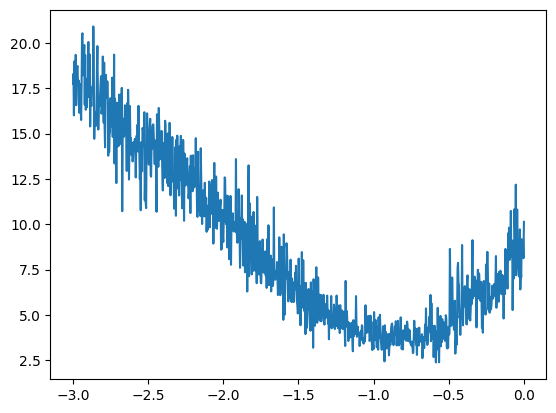

In [155]:
# Then pick lr = 10 ** -1.0
plt.plot(lri, lossi)

## Better evaluation
Train 80%, Validation 10%, Test 10%

In [176]:
import random
def build_dataset(words):
    block_size = 5 # context length
    xs, ys = [], []

    for word in words:
        context = [0] * block_size
        for ch in word+".":
            idx = stoi[ch]
            xs.append(context)
            ys.append(idx)
            context = context[1:] + [idx]
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

random.seed(42)
random.shuffle(names)
train_idx = int(0.8 * len(names))
val_idx = int(0.9 * len(names))
print(f"Training names: {train_idx}, Validation names: {val_idx-train_idx}, Test names: {len(names)-val_idx}")

print("--------------Training sample with context----------")
x_train, y_train = build_dataset(names[:train_idx])
print("--------------Validation sample with context----------")
x_val, y_val = build_dataset(names[train_idx:val_idx])
print("--------------Test sample with context----------")
x_test, y_test = build_dataset(names[val_idx:])

Training names: 25626, Validation names: 3203, Test names: 3204
--------------Training sample with context----------
torch.Size([182512, 5]) torch.Size([182512])
--------------Validation sample with context----------
torch.Size([22860, 5]) torch.Size([22860])
--------------Test sample with context----------
torch.Size([22774, 5]) torch.Size([22774])


* Solve Underfitting with wider hidden layer
* Larger embedding

In [210]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([27, 10], generator=g) # 32x5x27 * 27* 2 => 32x5x2
W1 = torch.randn([50, 300], generator=g) # Larger embedding and wider hidden layer
b1 = torch.randn(300, generator=g)
W2 = torch.randn([300, 27], generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [219]:
import math
steps = 60000
lr_pre = 0.1
lr_decay = 0.01

for step in range(steps):
    # Minibatch construct
    # Randomly sample from xs
    # Sample 32 samples from all xs indices
    idx = torch.randint(0, x_train.shape[0], (32,))
    
    # Fordward Pass
    emb = C[x_train[idx]]
    h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idx])
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    with torch.no_grad():
        for p in parameters:
            p += -lr_decay * p.grad

In [220]:
# Loss over all training samples
emb = C[x_train]
h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1860, grad_fn=<NllLossBackward0>)

In [221]:
# Loss over all val samples
emb = C[x_val]
h = torch.tanh(emb.view(-1, 50) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.2068, grad_fn=<NllLossBackward0>)

* 2.2912 for train and 2.2965 for val on 100 neurons per layer
* 2.2361 for train and 2.2514 for val on 300 neurons per layer
* 2.1860 for train and 2.2068 for val on 300 neurons per layer

## Visualize emb and scale up emb dim
similar character will cluster together.

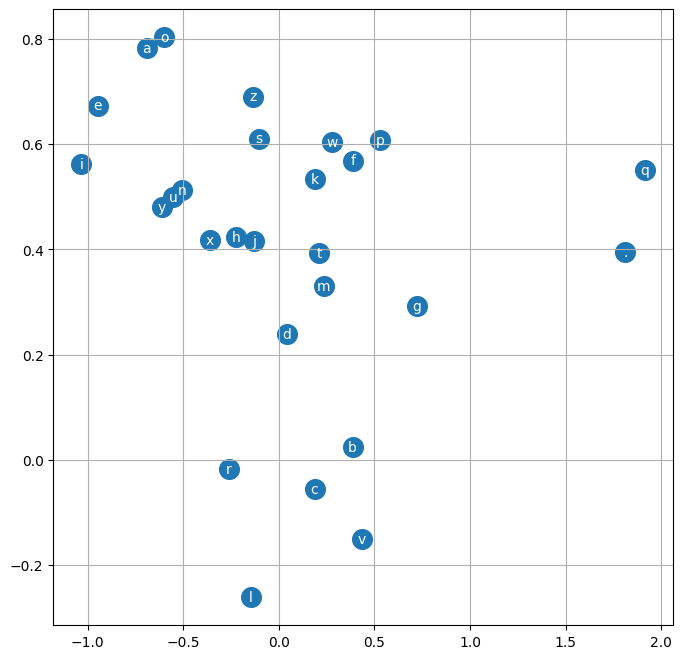

In [222]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")